In [1]:
from osdt.osdt import OSDT

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
)
from sklearn.model_selection import StratifiedKFold, train_test_split

from ucimlrepo import fetch_ucirepo

### Data & Visualisation

Binary classification

432 instances

6 features -> 15 features

In [3]:
# fetch dataset
monk = fetch_ucirepo(id=70)

# data (as pandas dataframes)
X = monk.data.features

In [4]:
multi_value = ["a1", "a2", "a4", "a5"]
binary_value = ["a3", "a6"]

def convert_finite_integer_to_categorical(
    feature_encoding: npt.NDArray[np.int64],
) -> tuple[npt.NDArray[np.int64], npt.NDArray[np.int64]]:
    """
    Convert a finite integer column to a set of categorical columns.
    Args:
        feature_encoding: A 1D numpy array of integers.
    Returns:
        A tuple of two numpy arrays:
        - The first array is the unique values of the input array.
        - The second array is the one-hot encoding of the input array.
    """
    unique_values = np.sort(np.unique(feature_encoding))
    one_hot = np.zeros((len(feature_encoding), len(unique_values)), dtype=int)
    for i, f in enumerate(feature_encoding):
        one_hot[i, np.where(unique_values == f)[0]] = 1

    return unique_values, one_hot

In [5]:
feature_names = []
X_np = None

for col in X.columns:
    if col in multi_value:
        # if there is nan in this column, replace it with -1
        col_np = X[col].to_numpy(dtype=np.int64)
        unique_values, col_one_hot = convert_finite_integer_to_categorical(col_np)
        for val in unique_values:
            feature_names.append(f"{col}_{val}")
        if X_np is None:
            X_np = col_one_hot
        else:
            X_np = np.column_stack((X_np, col_one_hot))
    elif col in binary_value:
        col_np = X[col].copy().to_numpy(dtype=np.int64)
        col_np -= 1 # make it 0-based
        feature_names.append(f"{col}_2")
        if X_np is None:
            X_np = col_np
        else:
            X_np = np.column_stack((X_np, col_np))

y_np = monk.data.targets.to_numpy().flatten()

print(f"X shape: {X_np.shape}")
print(f"y shape: {y_np.shape}")


X shape: (432, 15)
y shape: (432,)


In [6]:
train_X, hold_out_test_X, train_y, hold_out_test_y = train_test_split(
    X_np, y_np, test_size=0.3, random_state=73, stratify=y_np
)

In [7]:
train_y.mean(), hold_out_test_y.mean()

(0.5, 0.5)

In [8]:
# check if train_X is only binary values
np.all(np.isin(train_X, [0, 1]))

# convert train_X to int array
train_X = train_X.astype(int)
# convert hold_out_test_X to int array
hold_out_test_X = hold_out_test_X.astype(int)

# convert train_y to int array
train_y = train_y.astype(int)
# convert hold_out_test_y to int array
hold_out_test_y = hold_out_test_y.astype(int)

### Common code

In [9]:
# Config
NUM_FOLD = 5
RANDOM_STATE = 73

In [10]:
def get_fold_print_string(fold_result: list[float]):
    mean = np.mean(fold_result)
    ste = np.std(fold_result) / np.sqrt(NUM_FOLD)
    return f"{mean:.3f} ± {ste:.3f}"

## OSDT

Model OSDT with 5-fold cross-validation

nrule: 15
ndata: 241
gr: [7.22417589e-04 3.68222909e-03 1.09853236e-03 4.21566395e-04
 1.36169122e-03 2.09117242e-04 7.76938144e-05 2.78975168e-04
 4.32655820e-04 1.63875834e-05 1.56179376e-01 2.65925218e-02
 1.41829507e-02 1.09274628e-02 7.05863182e-04]
order: [10, 11, 12, 13, 1, 4, 2, 0, 14, 8, 3, 7, 5, 6, 9]
odr: [10, 11, 12, 13, 1, 4, 2, 0, 14, 8, 3, 7, 5, 6, 9]
the order of x's columns:  [10, 11, 12, 13, 1, 4, 2, 0, 14, 8, 3, 7, 5, 6, 9]
>>> log: False
>>> support bound: True
>>> accu_support: True
>>> accurate support bound: True
>>> equiv points bound: True
>>> lookahead bound: True
prior_metric= curiosity
COUNT_UNIQLEAVES: 1540
COUNT_LEAFLOOKUPS: 36744
total time:  1.4817075729370117
lambda:  0.025
leaves:  [(1,), (-11, -1, 8), (-1, 8, 11), (-8, -7, -6, -1), (-8, -7, -1, 6), (-13, -8, -1, 7), (-8, -1, 7, 13)]
num_captured:  [57, 39, 24, 44, 15, 38, 24]
num_captured_incorrect:  [0, 0, 0, 0, 0, 0, 0]
prediction:  [1, 0, 1, 0, 1, 0, 1]
Obje

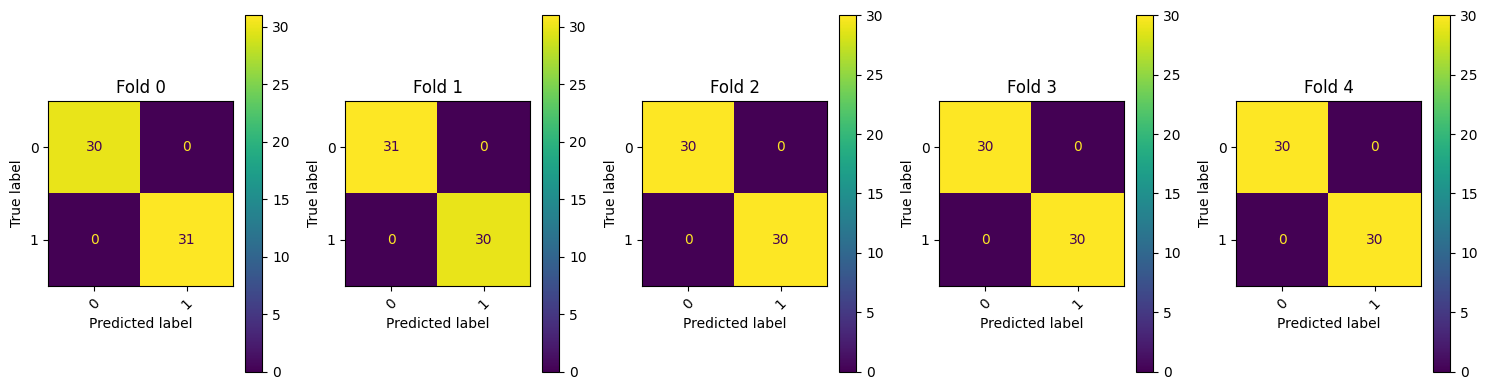

In [11]:
model = OSDT(lamb=0.025, prior_metric="curiosity", saveTree=True)

print(f"Model OSDT with {NUM_FOLD}-fold cross-validation\n")
skf = StratifiedKFold(
    n_splits=NUM_FOLD, shuffle=True, random_state=RANDOM_STATE
)

fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []
fold_mcc = []

hold_out_accuracy = []
hold_out_precision = []
hold_out_recall = []
hold_out_f1 = []
hold_out_mcc = []

fig, ax = plt.subplots(1, 5, figsize=(15, 4))
for i, (train_index, test_index) in enumerate(skf.split(train_X, train_y)):
    model.fit(train_X[train_index], train_y[train_index])

    y_pred = model.predict(train_X[test_index])

    acc = accuracy_score(train_y[test_index], y_pred)
    prec = precision_score(train_y[test_index], y_pred, zero_division=0)
    rec = recall_score(train_y[test_index], y_pred)
    f1 = f1_score(train_y[test_index], y_pred)
    mcc = matthews_corrcoef(train_y[test_index], y_pred)
    fold_accuracy.append(acc)
    fold_precision.append(prec)
    fold_recall.append(rec)
    fold_f1.append(f1)
    fold_mcc.append(mcc)
    print(
        f"Fold {i}: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Test on hold-out test set
    y_hold_out_pred = model.predict(hold_out_test_X)

    acc = accuracy_score(hold_out_test_y, y_hold_out_pred)
    prec = precision_score(hold_out_test_y, y_hold_out_pred, zero_division=0)
    rec = recall_score(hold_out_test_y, y_hold_out_pred)
    f1 = f1_score(hold_out_test_y, y_hold_out_pred)
    mcc = matthews_corrcoef(hold_out_test_y, y_hold_out_pred)
    hold_out_accuracy.append(acc)
    hold_out_precision.append(prec)
    hold_out_recall.append(rec)
    hold_out_f1.append(f1)
    hold_out_mcc.append(mcc)
    print(
        f"Hold-out Test: Accuracy={acc:.4f}, Precision={prec:.4f}, "
        f"Recall={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}"
    )

    # Plot confusion matrix
    cm = confusion_matrix(train_y[test_index], y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax[i], xticks_rotation=45)
    ax[i].set_title(f"Fold {i}")

print("\nCross-Validation Results:")
print(f"Mean Accuracy: {get_fold_print_string(fold_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(fold_precision)}")
print(f"Mean Recall: {get_fold_print_string(fold_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(fold_f1)}")
print(f"Mean MCC: {get_fold_print_string(fold_mcc)}")

print("\nHold-out Test Results:")
print(f"Mean Accuracy: {get_fold_print_string(hold_out_accuracy)}")
print(f"Mean Precision: {get_fold_print_string(hold_out_precision)}")
print(f"Mean Recall: {get_fold_print_string(hold_out_recall)}")
print(f"Mean F1 Score: {get_fold_print_string(hold_out_f1)}")
print(f"Mean MCC: {get_fold_print_string(hold_out_mcc)}")

plt.tight_layout()

[(1,), (-11, -1, 8), (-1, 8, 11), (-14, -12, -8, -1), (-12, -8, -1, 14), (-10, -8, -1, 12), (-8, -1, 10, 12)]


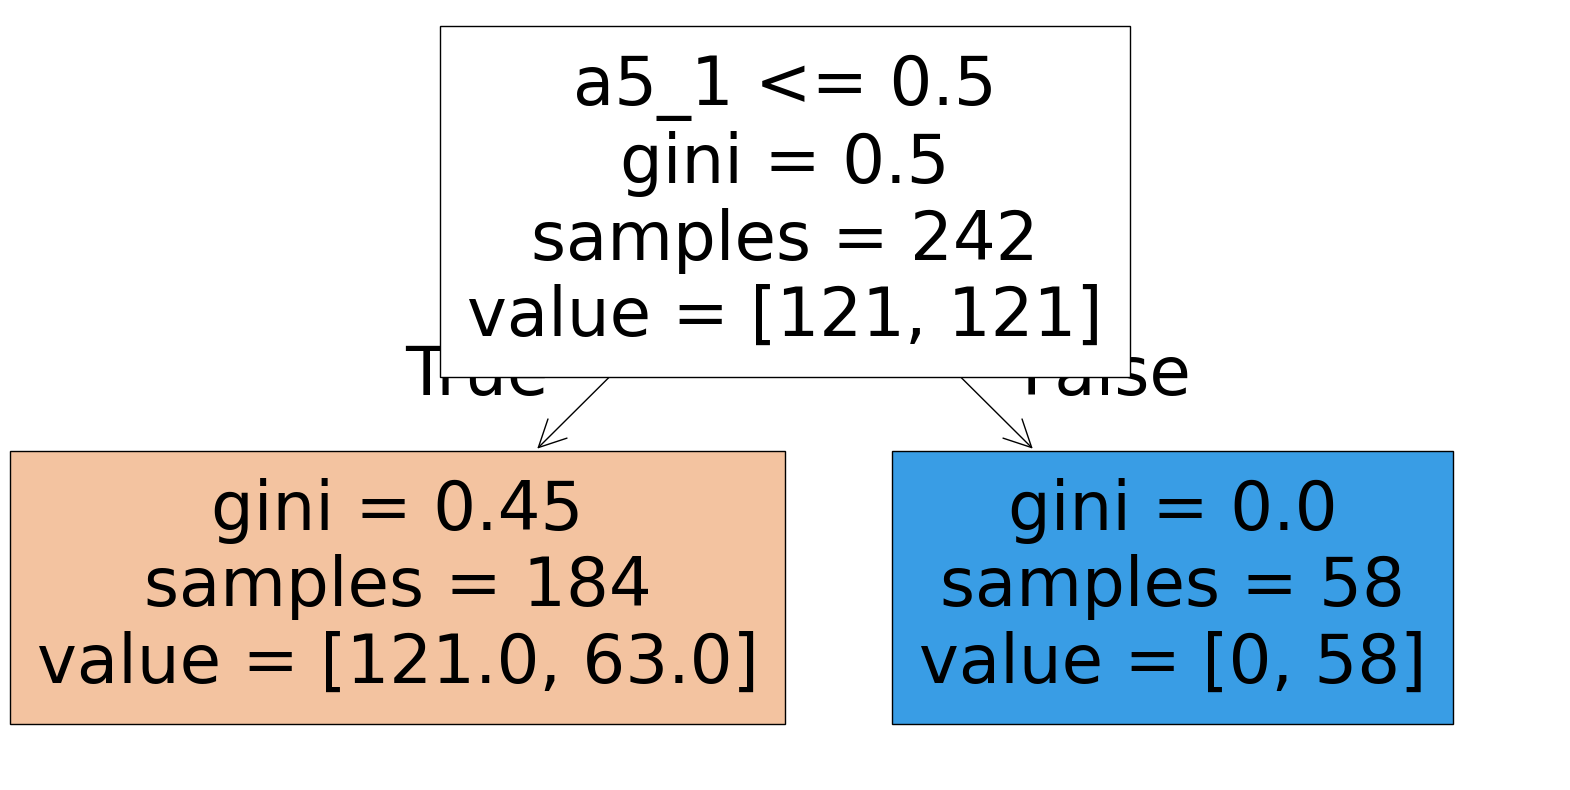

In [12]:
# display the decision tree
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(model.clf, filled=True, feature_names=feature_names)

print(model.leaves_c)